<a href="https://colab.research.google.com/github/qiiwen/IBM-HR-Analytics/blob/main/IBM_HR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import RFECV, RFE, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import tree
from itertools import product
from pandas.api.types import is_numeric_dtype

df = pd.read_csv("/content/WA_Fn-UseC_-HR-Employee-Attrition.csv")
df.head()

Age Attrition  ... YearsSinceLastPromotion  YearsWithCurrManager
0   41       Yes  ...                       0                     5
1   49        No  ...                       1                     7
2   37       Yes  ...                       0                     0
3   33        No  ...                       3                     0
4   27        No  ...                       2                     2

[5 rows x 35 columns]

In [ ]:
# drop irrelevant columns
df.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis="columns", inplace=True)

In [ ]:
# check for missing data
df1 = df[df.isna().any(axis=1)]
df1.head()

Empty DataFrame
Columns: [Age, Attrition, BusinessTravel, DailyRate, Department, DistanceFromHome, Education, EducationField, EnvironmentSatisfaction, Gender, HourlyRate, JobInvolvement, JobLevel, JobRole, JobSatisfaction, MaritalStatus, MonthlyIncome, MonthlyRate, NumCompaniesWorked, OverTime, PercentSalaryHike, PerformanceRating, RelationshipSatisfaction, StockOptionLevel, TotalWorkingYears, TrainingTimesLastYear, WorkLifeBalance, YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrManager]
Index: []

**Exploratory data analysis**

In [ ]:
def add_proportion(x, hue, catp, df):
  class_order = df[x].unique()
  if is_numeric_dtype(df[x]):
    class_order.sort()
  hue_order = df[hue].unique()
  bar_order = product(hue_order, class_order)
  spots = zip(catp.patches, bar_order)
  for spot in spots:
    gender_total = len(df[df[hue]==spot[1][0]])
    class_subtotal = len(df[(df[x]==spot[1][1]) & (df[hue]==spot[1][0])])
    height = spot[0].get_height() 
    catp.text(spot[0].get_x(), height+3, '{:1.2f}'.format(class_subtotal/gender_total))

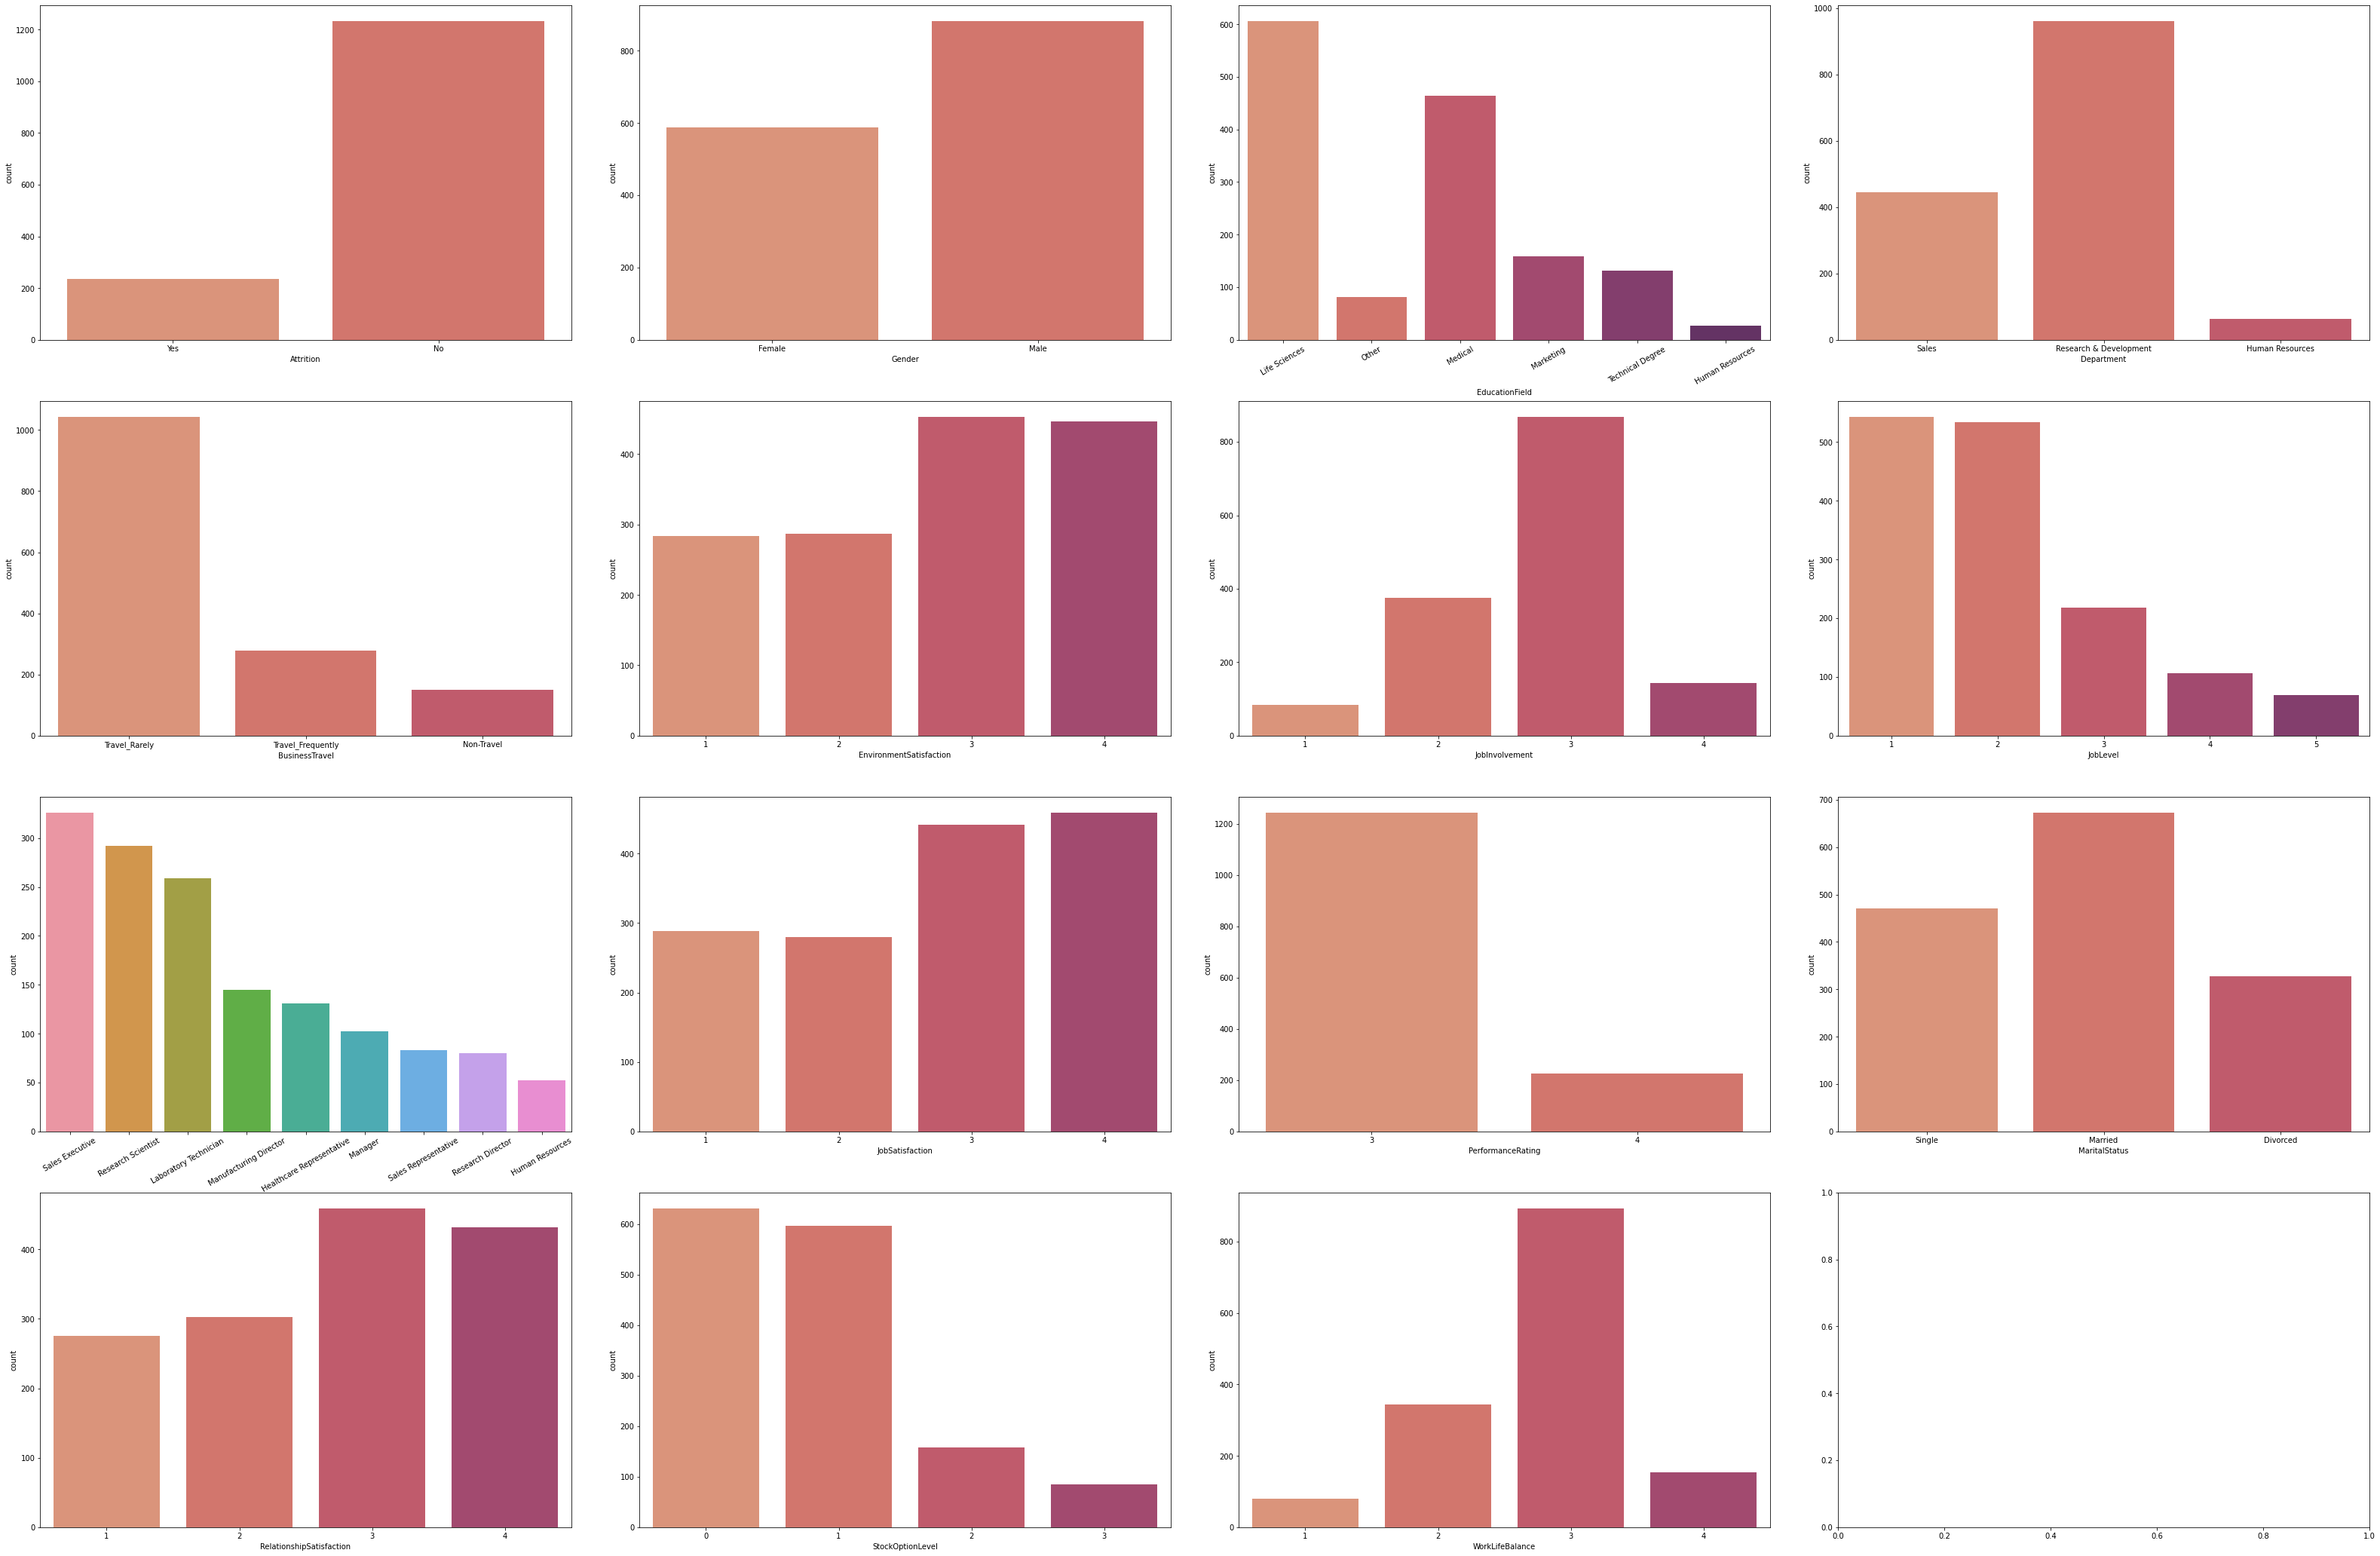

In [ ]:
# explore categorical / ordinal variables
sns.set_palette("flare")
fig, axs = plt.subplots(4,4, figsize=(45,30))
fig.tight_layout(pad=6.0)
catvar= ["Attrition", "Gender", "EducationField", "Department", "BusinessTravel", "EnvironmentSatisfaction", "JobInvolvement", "JobLevel", "JobRole", "JobSatisfaction", "PerformanceRating", "MaritalStatus", "RelationshipSatisfaction", "StockOptionLevel", "WorkLifeBalance"]

k = 0
for i in range(4):
  for j in range(4):
    try:
      plot = sns.countplot(x=catvar[k], data=df, ax=axs[i,j])
      if len(df[catvar[k]].unique()) > 3 and df.dtypes[catvar[k]] == np.object:
        plot.set_xticklabels(plot.get_xticklabels(), rotation=30)
      k += 1
    except:
      break

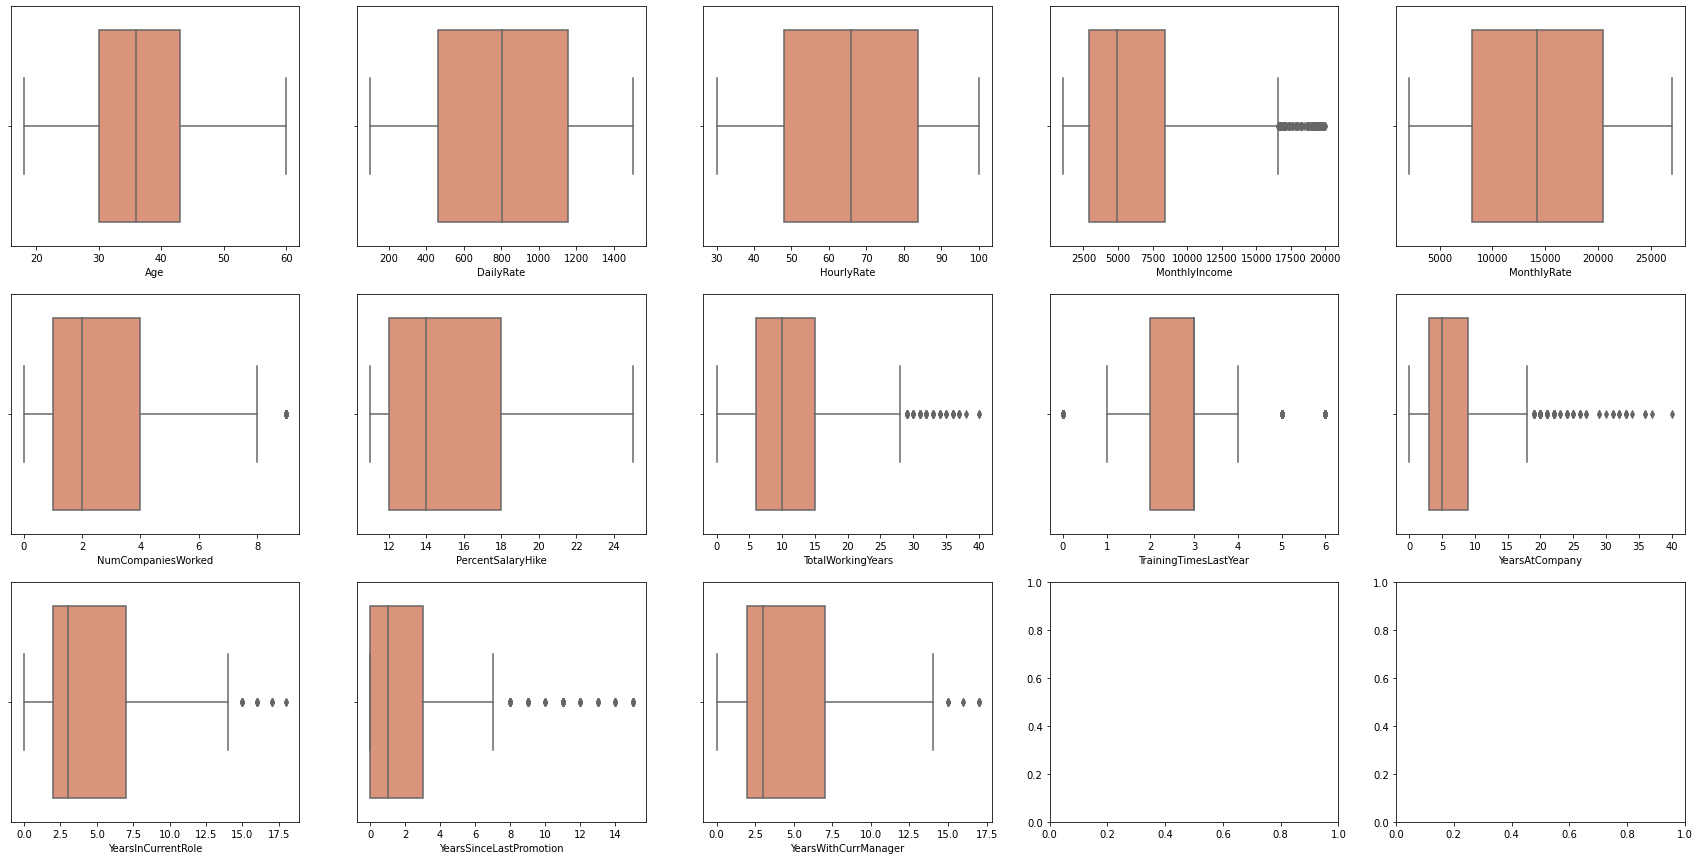

In [ ]:
# detect univariate numerical outliers
fig, axs = plt.subplots(3,5, figsize=(30,15))
numvar = ["Age", "DailyRate", "HourlyRate", "MonthlyIncome", "MonthlyRate", "NumCompaniesWorked", "PercentSalaryHike", "TotalWorkingYears", "TrainingTimesLastYear", "YearsAtCompany", "YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager"]
k = 0
for i in range(3):
  for j in range(5):
    try:
      plot = sns.boxplot(x=numvar[k], data=df, ax=axs[i,j])
      k += 1
    except:
      break

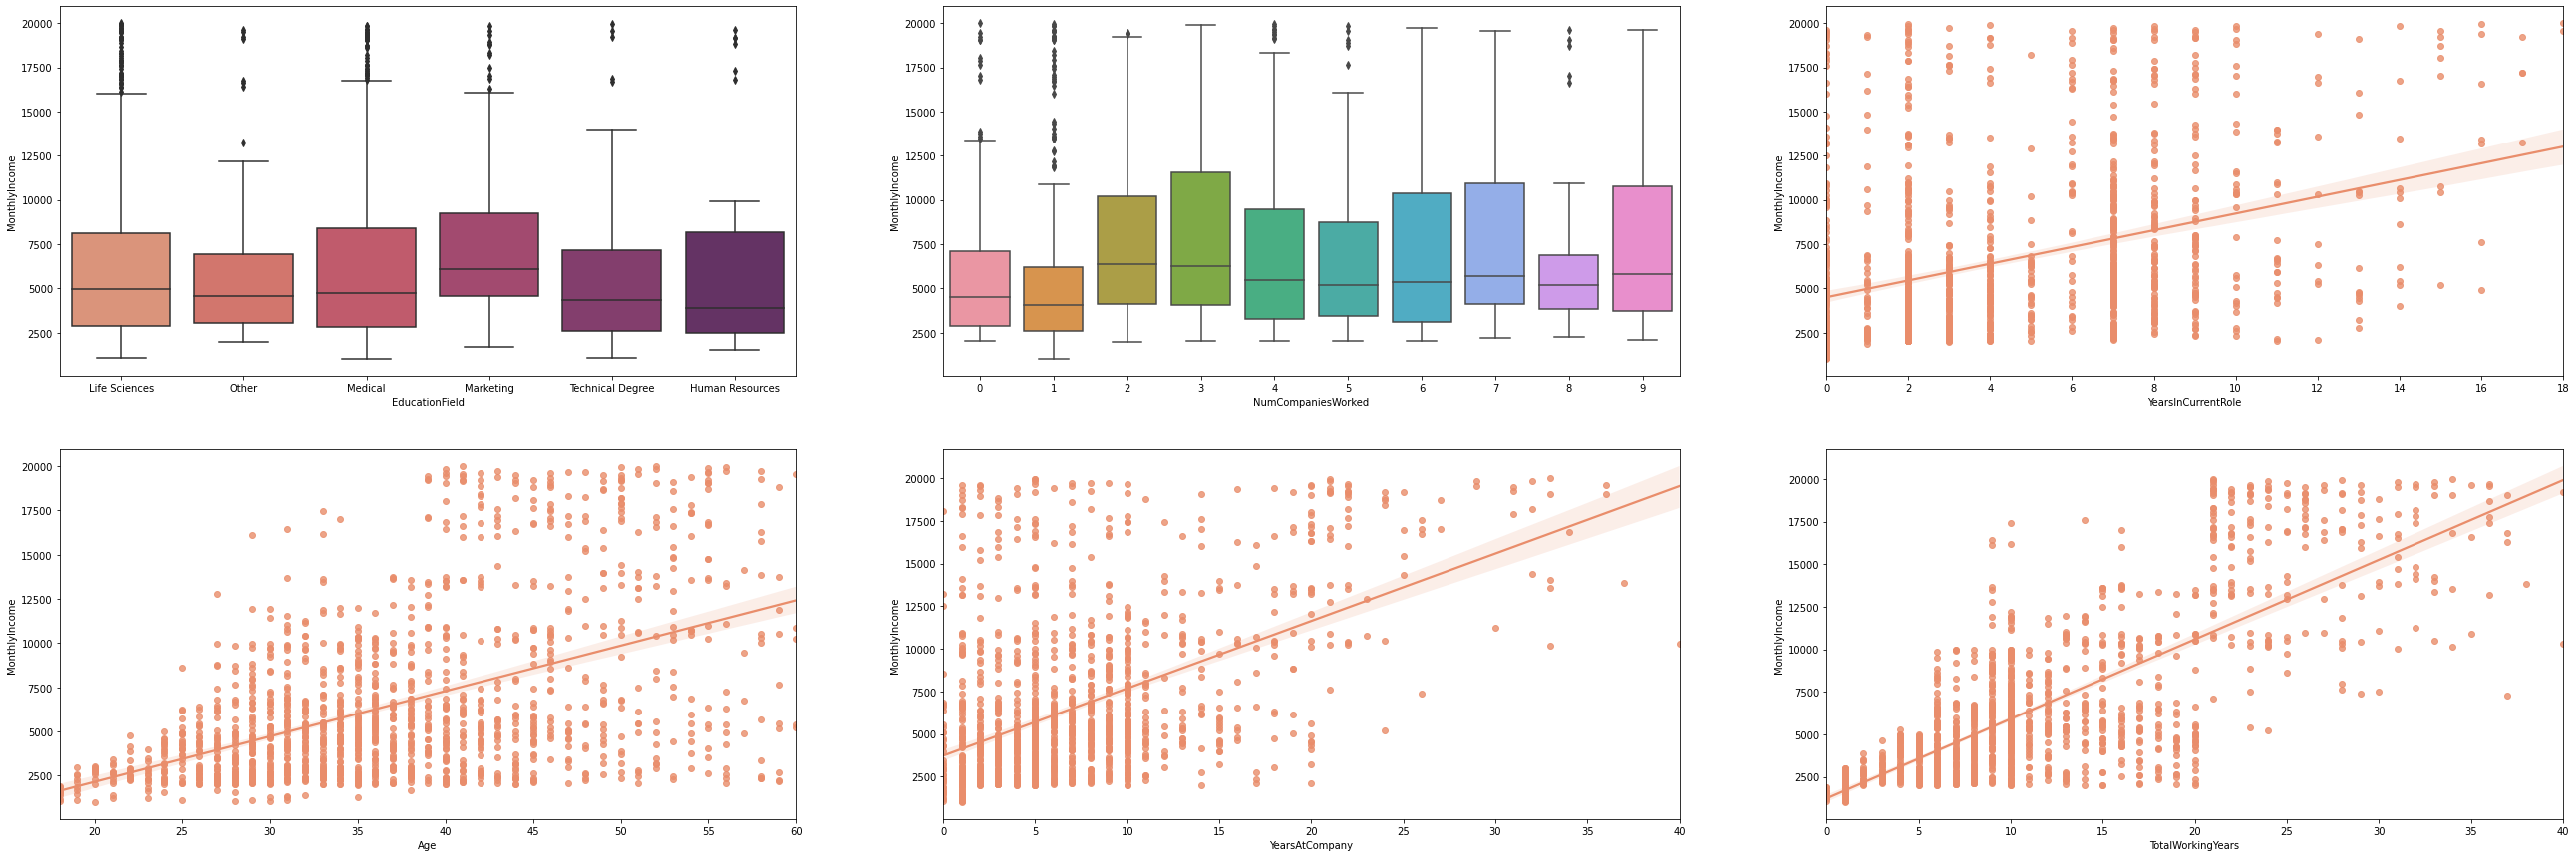

In [ ]:
# explore outliers in Monthly Income
fig, axs = plt.subplots(2,3, figsize=(45,15))
sns.boxplot(x="EducationField", y="MonthlyIncome", data=df, ax=axs[0,0])
sns.boxplot(x="NumCompaniesWorked", y="MonthlyIncome", data=df, ax=axs[0,1])
sns.regplot(x="YearsInCurrentRole", y="MonthlyIncome", data=df, ax=axs[0,2])
sns.regplot(x="Age", y="MonthlyIncome", data=df, ax=axs[1,0])
sns.regplot(x="YearsAtCompany", y="MonthlyIncome", data=df, ax=axs[1,1])
sns.regplot(x="TotalWorkingYears", y="MonthlyIncome", data=df, ax=axs[1,2])

In [ ]:
print(np.corrcoef(df["YearsInCurrentRole"], df["MonthlyIncome"]))
print(np.corrcoef(df["Age"], df["MonthlyIncome"]))
print(np.corrcoef(df["YearsAtCompany"], df["MonthlyIncome"]))
print(np.corrcoef(df["TotalWorkingYears"], df["MonthlyIncome"]))

[[1.         0.36381767]
 [0.36381767 1.        ]]
[[1.         0.49785457]
 [0.49785457 1.        ]]
[[1.         0.51428483]
 [0.51428483 1.        ]]
[[1.         0.77289325]
 [0.77289325 1.        ]]


'MonthlyIncome' is strongly correlated with 'TotalWorkingYears' which suggests that the outliers may be salaries of senior working executives

[[1.         0.68038054]
 [0.68038054 1.        ]]


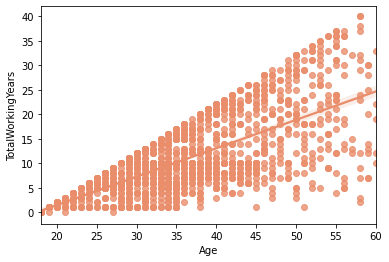

In [ ]:
# explore outliers in total working years
sns.regplot(x="Age", y="TotalWorkingYears", data=df)
print(np.corrcoef(df["Age"], df["TotalWorkingYears"]))

'TotalWorkingYears' is correlated with 'Age' which suggest that the outliers may be due to senior working staff

**Gender Analysis**

Discover the dataset through widely discussed workplace issues and check if there are any anomalies

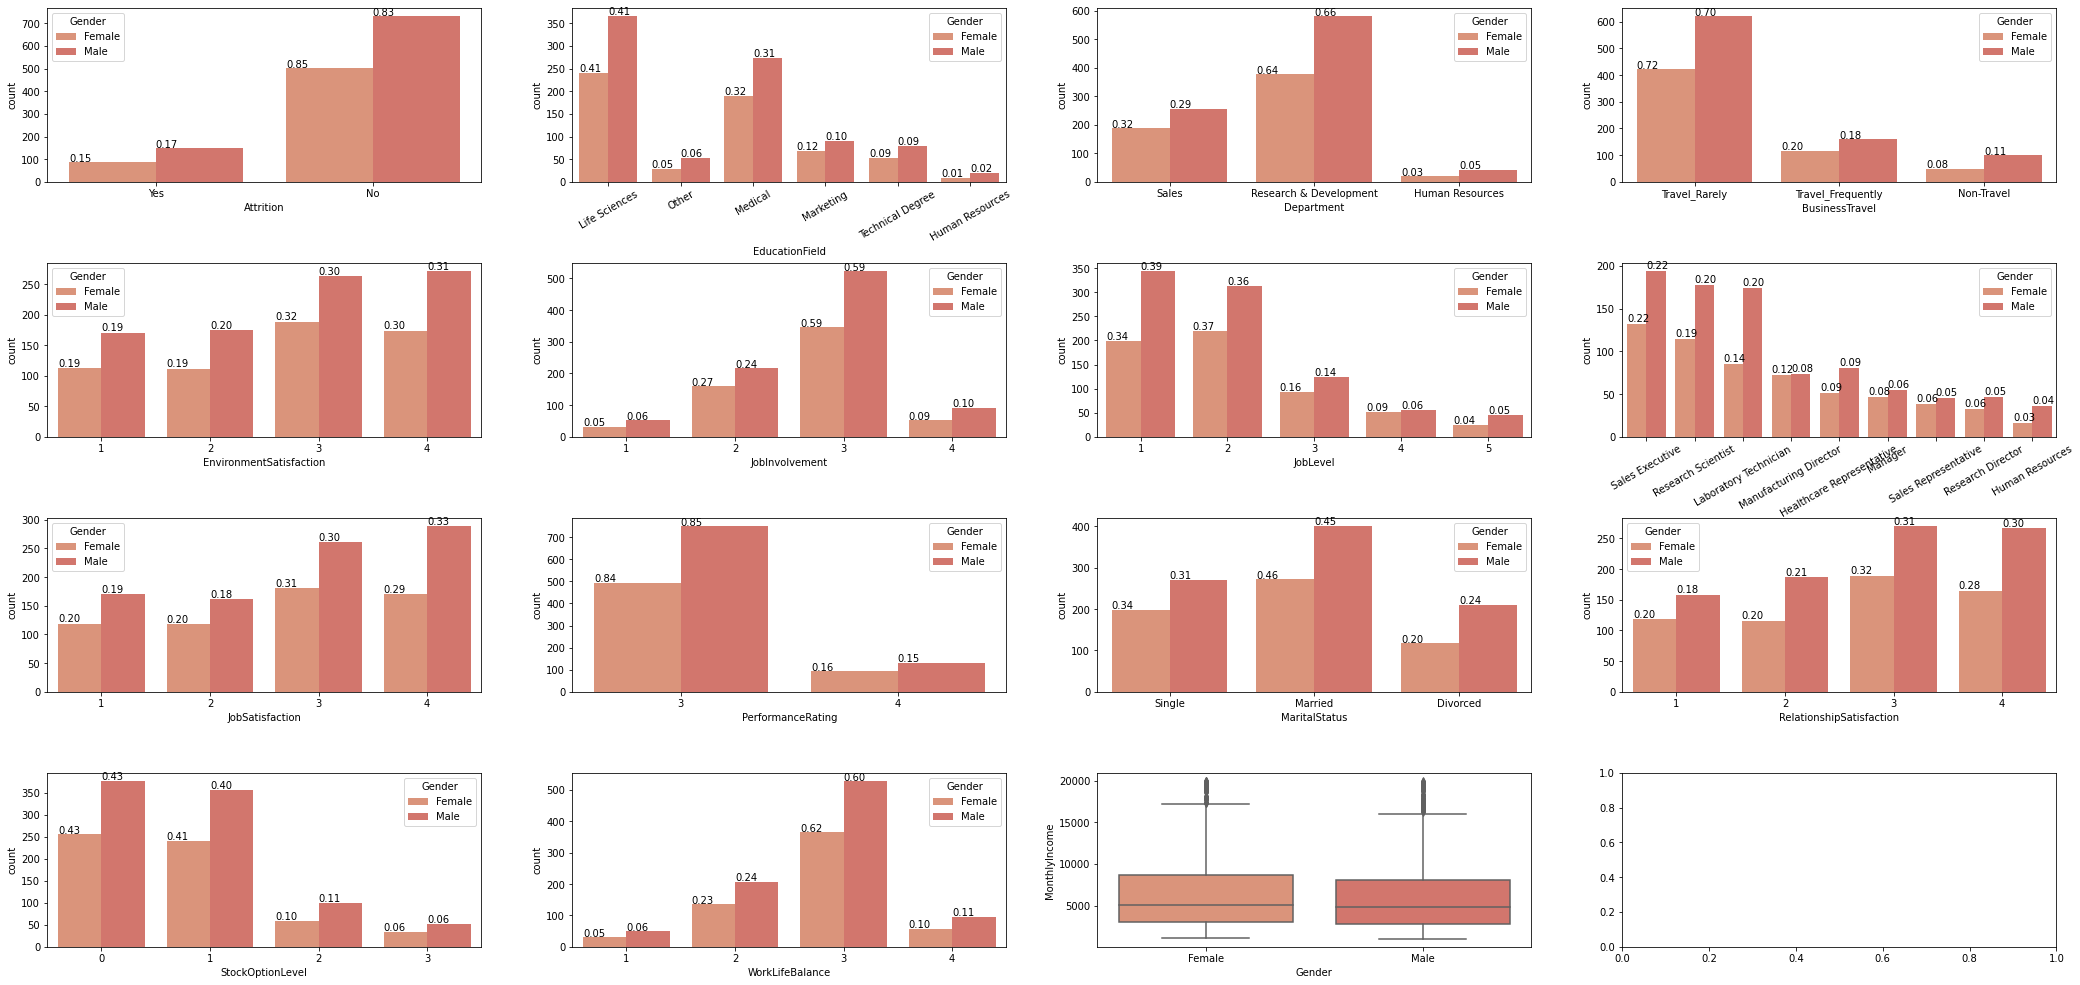

In [ ]:
# explore categorical / ordinal variables
fig, axs = plt.subplots(4,4, figsize=(30,15))
fig.tight_layout(pad=6.0)
catvar= ["Attrition", "EducationField", "Department", "BusinessTravel", "EnvironmentSatisfaction", "JobInvolvement", "JobLevel", "JobRole", "JobSatisfaction", "PerformanceRating", "MaritalStatus", "RelationshipSatisfaction", "StockOptionLevel", "WorkLifeBalance"]

k = 0
for i in range(4):
  for j in range(4):
    try:
      plot = sns.countplot(x=catvar[k], hue="Gender", data=df, ax=axs[i,j])
    except:
      break
    if len(df[catvar[k]].unique()) > 3 and df.dtypes[catvar[k]] == np.object:
        plot.set_xticklabels(plot.get_xticklabels(), rotation=30)
    add_proportion(catvar[k], "Gender", plot, df)
    k += 1
sns.boxplot(x="Gender", y="MonthlyIncome", data=df, ax=axs[3,2])

'JobLevel': 
There is a higher proportion of females than males at JobLevel 4 and this relationship is reversed at JobLevel 5. This may suggest that females are less likely to reach top positions, but the data is not conclusive and further investigation is needed.

'JobRole':
Relatively equal proportion of females and males in the director positions.

Overall, the categorical data is similar between males and females.

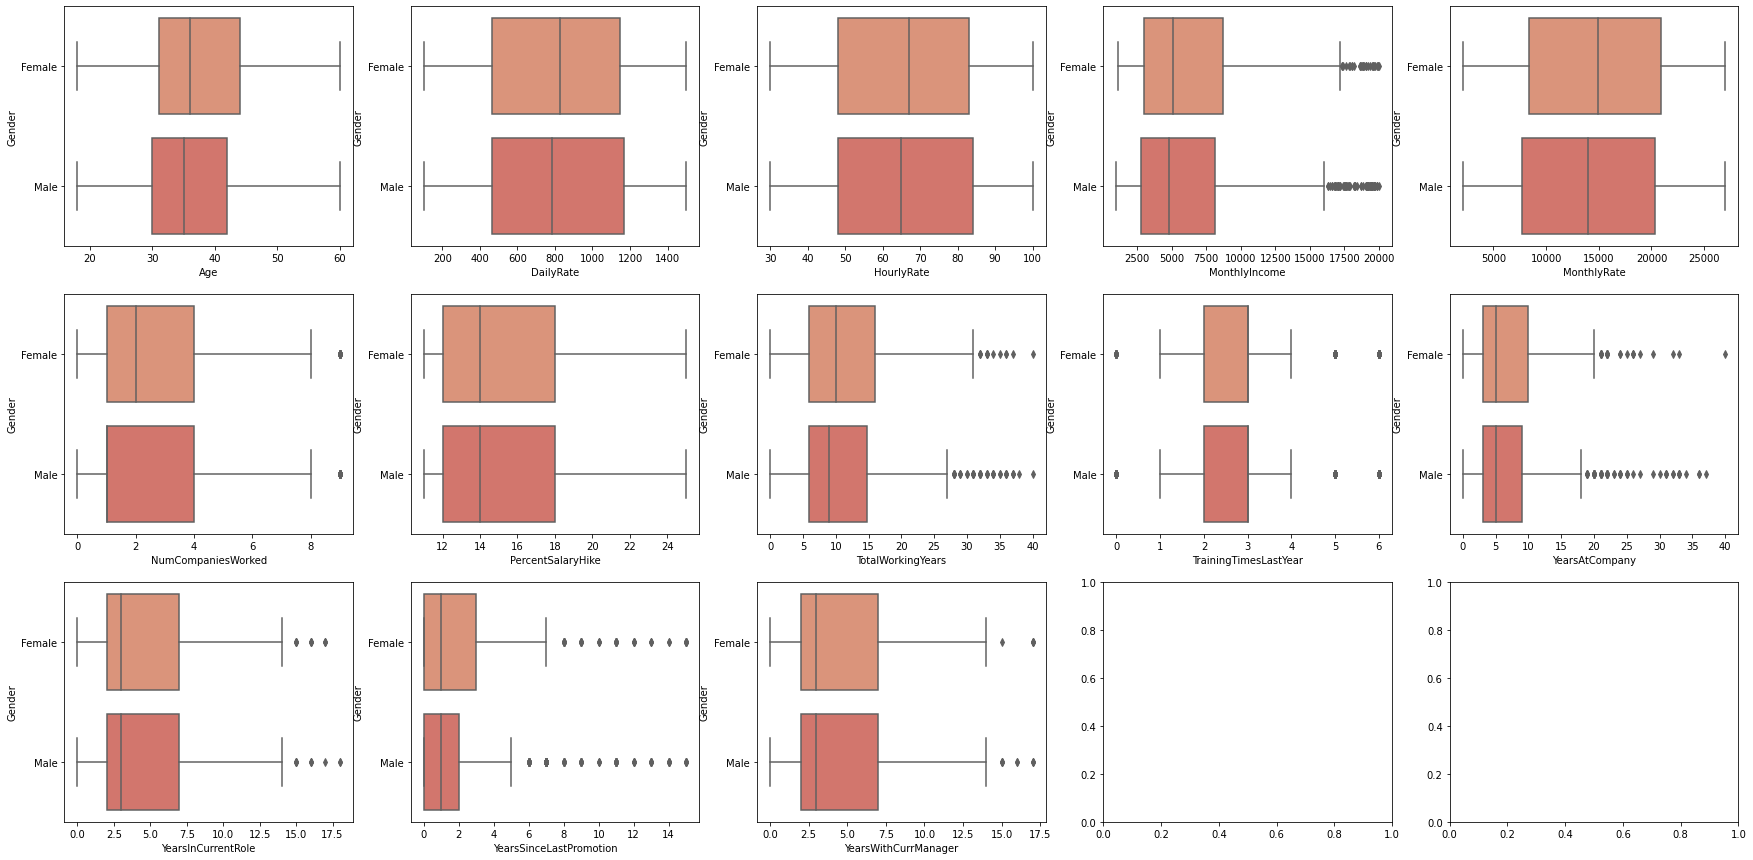

In [ ]:
# numerical values by gender
fig, axs = plt.subplots(3,5, figsize=(30,15))
sns.boxplot(x="Age", y="Gender", data=df, ax=axs[0,0])
sns.boxplot(x="DailyRate", y="Gender", data=df, ax=axs[0,1])
sns.boxplot(x="HourlyRate", y="Gender", data=df, ax=axs[0,2])
sns.boxplot(x="MonthlyIncome", y="Gender", data=df, ax=axs[0,3])
sns.boxplot(x="MonthlyRate", y="Gender", data=df, ax=axs[0,4])
sns.boxplot(x="NumCompaniesWorked", y="Gender", data=df, ax=axs[1,0])
sns.boxplot(x="PercentSalaryHike", y="Gender", data=df, ax=axs[1,1])
sns.boxplot(x="TotalWorkingYears", y="Gender", data=df, ax=axs[1,2])
sns.boxplot(x="TrainingTimesLastYear", y="Gender", data=df, ax=axs[1,3])
sns.boxplot(x="YearsAtCompany", y="Gender", data=df, ax=axs[1,4])
sns.boxplot(x="YearsInCurrentRole", y="Gender", data=df, ax=axs[2,0])
sns.boxplot(x="YearsSinceLastPromotion", y="Gender", data=df, ax=axs[2,1])
sns.boxplot(x="YearsWithCurrManager", y="Gender", data=df, ax=axs[2,2])

It seems like there are no large differences between male and female for the numerical variables

**Further data processing for numerical analysis**

In [ ]:
# split into input (X) and output (Y) variables
X = df.iloc[:, 2:]
X['Age'] = df.iloc[:, 0]
Y = df.iloc[:, 1]
print(X[:5])
print(Y[:5])

      BusinessTravel  DailyRate  ... YearsWithCurrManager  Age
0      Travel_Rarely       1102  ...                    5   41
1  Travel_Frequently        279  ...                    7   49
2      Travel_Rarely       1373  ...                    0   37
3  Travel_Frequently       1392  ...                    0   33
4      Travel_Rarely        591  ...                    2   27

[5 rows x 30 columns]
0    Yes
1     No
2    Yes
3     No
4     No
Name: Attrition, dtype: object


In [ ]:
# encode categorical variables
catvar = ['BusinessTravel', 'JobRole', 'Department', 'EducationField', 'Gender', 'MaritalStatus', 'OverTime', 'StockOptionLevel']
X_cat = X.loc[:, catvar]
oe = OrdinalEncoder()
oe.fit(X_cat)
X_cat2 = oe.transform(X_cat)
X_cat = pd.DataFrame(X_cat2, columns = X_cat.columns)


# get numerical variables (includes ordinal variables)
numvar = ['DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'WorkLifeBalance',  'PerformanceRating', 'RelationshipSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
X_num = X.loc[:, numvar]

# combine all X 
X = pd.concat([X_num.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)


# encode dependent variables
oe = OrdinalEncoder()
oe.fit(Y.values.reshape(-1,1))
Y = oe.transform(Y.values.reshape(-1,1))

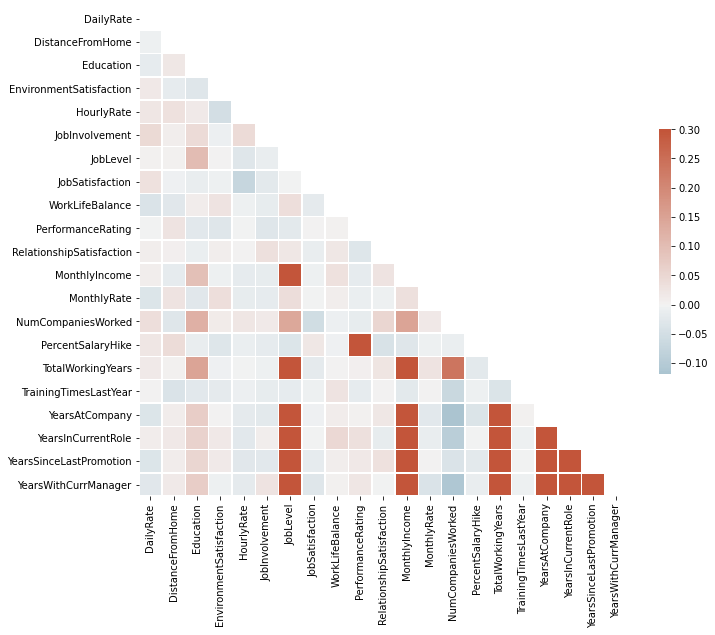

In [ ]:
# Compute the correlation matrix for numeric variables
corr = X_num.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

**Data modelling**

In [ ]:
# split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=1)
# summarize
print('Train', X_train.shape, Y_train.shape)
print('Test', X_test.shape, Y_test.shape)

Train (984, 29) (984, 1)
Test (486, 29) (486, 1)


In [ ]:
# recursive feature elimination
rfe = RFECV(estimator=LogisticRegression(solver='lbfgs', max_iter=10000))

# Fit to the training data
_ = rfe.fit(X_train, Y_train.ravel())

X_train_reduced = X_train.loc[:, rfe.support_]
print(X_train_reduced.columns)

Index(['DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction',
       'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction',
       'WorkLifeBalance', 'PerformanceRating', 'RelationshipSatisfaction',
       'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'BusinessTravel',
       'JobRole', 'Department', 'EducationField', 'Gender', 'MaritalStatus',
       'OverTime', 'StockOptionLevel'],
      dtype='object')


In [ ]:
logit_model = sm.Logit(Y_train,X_train_reduced)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.319195
         Iterations 7
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.258     
Dependent Variable:    y                  AIC:                682.1752  
Date:                  2021-08-18 09:55   BIC:                814.2491  
No. Observations:      984                Log-Likelihood:     -314.09   
Df Model:              26                 LL-Null:            -423.50   
Df Residuals:          957                LLR p-value:        2.0923e-32
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        7.0000                                           
------------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------
DailyRate                -0.0003   0.0003 -1.3817 0

In [ ]:
X_test_reduced = X_test.loc[:, rfe.support_]
logit_model = sm.Logit(Y_test,X_test_reduced)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.301660
         Iterations 8
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.349     
Dependent Variable:    y                  AIC:                347.2135  
Date:                  2021-08-18 09:55   BIC:                460.2412  
No. Observations:      486                Log-Likelihood:     -146.61   
Df Model:              26                 LL-Null:            -225.29   
Df Residuals:          459                LLR p-value:        9.2897e-21
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        8.0000                                           
------------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------
DailyRate                -0.0002   0.0004 -0.5281 0

In [ ]:
# select features based on importance
clf = RandomForestClassifier(n_estimators=100, 
                            max_depth=4,
                            max_features='auto', 
                            min_samples_leaf=4)
sfm = SelectFromModel(clf)
sfm.fit(X_train,Y_train)

X_train_reduced = X_train.loc[:, sfm.get_support()]
print(X_train_reduced.columns)

Index(['DailyRate', 'DistanceFromHome', 'MonthlyIncome', 'TotalWorkingYears',
       'YearsAtCompany', 'YearsWithCurrManager', 'JobRole', 'MaritalStatus',
       'OverTime', 'StockOptionLevel'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_from_model.py:222: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


In [ ]:
def print_score(clf, X, Y):
    pred = clf.predict(X)
    clf_report = pd.DataFrame(classification_report(Y, pred, output_dict=True))
    print("Result:\n================================================")
    print(f"Accuracy Score: {accuracy_score(Y, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {confusion_matrix(Y, pred)}\n")

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100,
                                max_depth=4,
                                max_features='auto', 
                                min_samples_leaf=4)
X_test_reduced = X_test.loc[:, sfm.get_support()]
rf_clf.fit(X_train_reduced, Y_train.ravel())

print_score(rf_clf, X_train_reduced, Y_train.ravel())
print_score(rf_clf, X_test_reduced, Y_test.ravel())

Result:
Accuracy Score: 86.69%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision    0.863967    1.000000   0.86687    0.931983      0.884980
recall       1.000000    0.138158   0.86687    0.569079      0.866870
f1-score     0.927019    0.242775   0.86687    0.584897      0.821323
support    832.000000  152.000000   0.86687  984.000000    984.000000
_______________________________________________
Confusion Matrix: 
 [[832   0]
 [131  21]]

Result:
Accuracy Score: 83.13%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.834382   0.666667  0.831276    0.750524      0.805049
recall       0.992519   0.070588  0.831276    0.531553      0.831276
f1-score     0.906606   0.127660  0.831276    0.517133      0.770370
support    401.000000  85.000000  0.831276  486.000000    486.000000
_________

In [ ]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (15, 15), dpi=1200)
tree.plot_tree(rf_clf.estimators_[0], feature_names = X_train_reduced.columns, class_names = ['0', '1'], filled = True);
fig.savefig('tree.png')